# Machine Learning project 
## Decision Tree classifier
Dapueto Jacopo A.A. 2019/2020


In [1]:
# import libraries and my own files
import cv2
from scipy.interpolate import griddata
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import pandas
import numpy as np
import project_utils as utils # functions used in the notebook
from decisionTree import DecisionTree # containing my implementation
from sklearn.tree import DecisionTreeClassifier # Scikit implementation

# Datasets
in the following cells the datasets used in the notebook are prepared.

## Breast cancer dataset
A real dataset: https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

*What*: Diagnostic Wisconsin Breast Cancer

*Number of Instances*: 569

*Number of Attributes*: 30

*Classes*: Malignant or Benign

-1: 212
1: 357


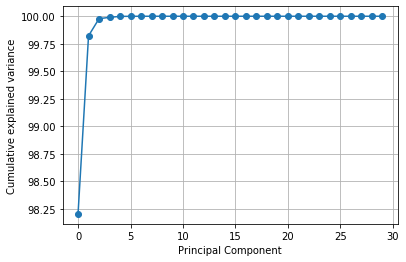

In [7]:
cancer=datasets.load_breast_cancer()
X_cancer = cancer.data 
X_cancer = utils.centering(X_cancer, X_cancer)

Y_cancer = cancer.target
Y_cancer[Y_cancer==0]=-1 # preparing the classes 
classes_cancer = [-1, 1]
print("-1:", list(Y_cancer).count(-1))
print("1:", list(Y_cancer).count(1))

k=3
attributes_cancer = [ [i] for i in range(k)]

PC, expl_var = utils.PCA(X_cancer, k)
X_cancer = utils.PCA_Project(X_cancer, PC)
pcidx = np.arange(len(expl_var))
plt.plot(pcidx, expl_var, '-o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')
plt.grid()

As we can see from the explained variance, the first 3 components of the data are enough: in the following code the data are considered so.

# Iris plants dataset
Description: https://scikit-learn.org/stable/datasets/index.html#iris-dataset

*Number of Instances*: 150

*Number of Attributes*: 4

*Classes*: Iris-Setosa, Iris-Versicolour, Iris-Virginica

In [4]:
iris = datasets.load_iris()
X_iris = iris.data 
X_iris = utils.centering(X_iris, X_iris)
Y_iris = iris.target
# preparing the classes 1...3 instead of 0...2
classes_iris = [i for i in range(3)]
for i in classes_iris[::-1] :
    Y_iris[Y_iris==i]= i+1
    
attributes_iris = [ [i] for i in range(4)]

### Generates data for classification
The function is the same used in the laboratories.

In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

### KFoldCVBestDepth_ScikitImplementation
Find the best max_depth parameter using Scikit's DecisionTreeClassifier. 
K-fold cross validation.

In [6]:
def KFoldCVBestDepth_ScikitImplementation(Xtr, Ytr, criterion, KF, max_depth_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    max_depth_list = np.array(max_depth_list)
    num_max_depth = max_depth_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_max_depth)
    Ts = np.zeros(num_max_depth)
    Vm = np.zeros(num_max_depth)
    Vs = np.zeros(num_max_depth)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, depth in enumerate(max_depth_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error for the given value of depth
            if criterion == DecisionTree.ENTROPY:
                clf = DecisionTreeClassifier(max_depth = depth, criterion ='entropy')
            else:
                clf = DecisionTreeClassifier(max_depth = depth) # gini is defualt
            trained = clf.fit(X, Y)
            
            trError = utils.calcError(clf.predict(X), Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error for the given value of depth
            valError = utils.calcError(clf.predict(X_val), Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_max_depth_idx = np.argmin(Vm)
    best_max_depth = max_depth_list[best_max_depth_idx]

    return [best_max_depth], Vm, Vs, Tm, Ts

### KFoldCVBestDepth_MyImplementation
Find the best max_depth parameter using my own DecisionTreeClassifier. K-fold cross validation.

In [7]:
def KFoldCVBestDepth_MyImplementation(Xtr, Ytr, attributes_list, classes, criterion, KF, max_depth_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    max_depth_list = np.array(max_depth_list)
    num_max_depth = max_depth_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_max_depth)
    Ts = np.zeros(num_max_depth)
    Vm = np.zeros(num_max_depth)
    Vs = np.zeros(num_max_depth)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, depth in enumerate(max_depth_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error for the given value of depth
            Dt = DecisionTree( depth, (X,Y), attributes_list, classes, criterion)
            Dt.train()
            
            trError = Dt.test(X,Y)[2]
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error for the given value of depth
            valError = Dt.test(X_val,Y_val)[2]
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_max_depth_idx = np.argmin(Vm)
    best_max_depth = max_depth_list[best_max_depth_idx]

    return [best_max_depth], Vm, Vs, Tm, Ts

# Linearly separable problem

Let's see how decision trees work with a simple linearly separable problem like a binary dataset.

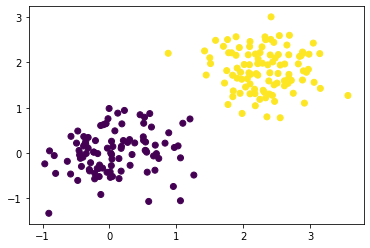

In [3]:
classes = [-1,1] # the label classes
attributes_list =[[0], [1]] # indexes of colum to be considered by the algorithm

Xtr, Ytr= mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100)
Xte, Yte= mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100)

plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr)

Decision tree devides the input space into axis-parallel rectangles: the space is divided according to a threshold over the dataset's attribute.

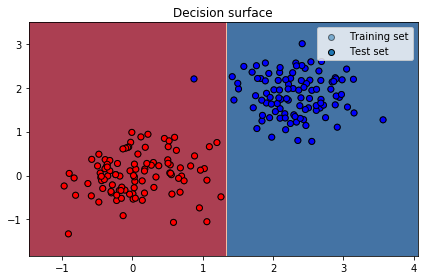

In [4]:
Dt = DecisionTree( 2, (Xtr,Ytr), attributes_list, classes, DecisionTree.ENTROPY) # we consider only the firt split
Dt.train() 
utils.Area(Dt, Xtr, Ytr, Xtr, Ytr) # training and test set are coincident in the plot



Considering only the first spit, the decision tree tries to split the classes maximizing the purity using the x-axis. 
The decision tree fixes a threshold which is used as a test in the following way:
1. `each point <= threshold` belongs to the red class
2. `each point > threshold` belongs to the blue class

The result is the plane divided into 2 parts such that the left part represents the red class and the other the blue class.
The dataset can be further splitted.

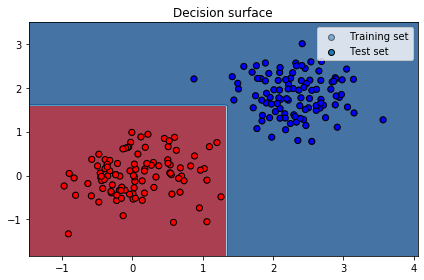

In [6]:
Dt = DecisionTree( 3, (Xtr,Ytr), attributes_list, classes, DecisionTree.ENTROPY) # considering firt and second split
Dt.train() 

utils.Area(Dt, Xtr, Ytr, Xtr, Ytr) # training and test set are coincident in the plot


Now the dataset is splitted according to the y-axis and the decision tree cannot grow anymore because all the tuples in the resulting partitions belong to the same classes; so all the tuples in the first partition belong to the red class and all the tuples of the second partition belong to the blue class. In this situation the algorithm is halted and the training set is perfectely classified.
In general the training set can be splitted using multiple times the same axis.

Test error:  0.0
Height:  2


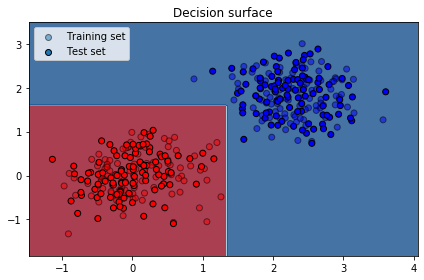

In [7]:
err = Dt.test(Xte, Yte) [2] 
print("Test error: ",err)
print("Height: ", Dt.getHeight())
utils.Area(Dt, Xtr, Ytr, Xte, Yte) # Ypred is not considered, the eventual misclassified point can be view from the plot

If the test set is evaluated using the model trained before, we get an error greater than the Training error (0.0), this happens because the model overfit the training set.

### Training set size

Can the training set's size affect the size of the tree (in terms of height)?

sizes:  [ 50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370 390
 410 430 450 470 490 510 530 550 570 590 610 630 650 670 690 710]


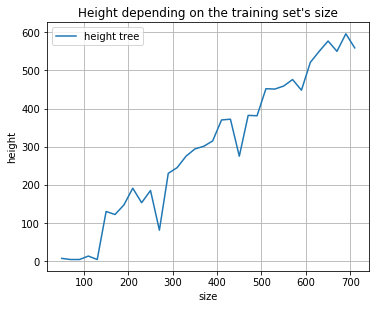

In [53]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # the label classes
attributes_list =[[0], [1]] # indexes of colum to be considered by the algorithm
step = 20
size_list = np.arange(50, 700 + step , step)
print("sizes: ", size_list)

depth_list = np.zeros(size_list.size)

for idx, size in enumerate(size_list):
    
    Xtr, Ytr= mixGauss([[0,0], [2,2]], [0.70, 0.70], size)
    Dt = DecisionTree( float('+inf') , (Xtr,Ytr), attributes_list, classes, DecisionTree.GINI) 
    Dt.train() 
    depth_list[idx] = Dt.getHeight()
    
plt.subplot(2,2,1)
plt.plot(size_list, depth_list, label= 'height tree')
plt.title("Height depending on the training set's size")
plt.xlabel('size')
plt.ylabel('height')
plt.axis("tight")
plt.legend()
plt.grid()

plt.tight_layout()

To generate data I used 0.70 as the standard deviations of the Gaussian functions in order to have a more evident result.

The size of the tree tends to encrease with the size of the training set probably because the two classes are about to overlap.

What if the same thing is done using 0.5 as standard deviation ?

sizes:  [ 50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370 390
 410 430 450 470 490 510 530 550 570 590 610 630 650 670 690 710]


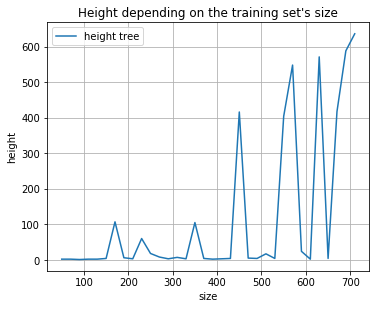

In [9]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # the label classes
attributes_list =[[0], [1]] # indexes of colum to be considered by the algorithm
step = 20
size_list = np.arange(50, 700 + step , step)
print("sizes: ", size_list)

depth_list = np.zeros(size_list.size)

for idx, size in enumerate(size_list):
    
    Xtr, Ytr= mixGauss([[0,0], [2,2]], [0.5, 0.5], size)
    Dt = DecisionTree( float('+inf') , (Xtr,Ytr), attributes_list, classes, DecisionTree.GINI) 
    Dt.train() 
    depth_list[idx] = Dt.getHeight()
    
plt.subplot(2,2,1)
plt.plot(size_list, depth_list, label= 'height tree')
plt.title("Height depending on the training set's size")
plt.xlabel('size')
plt.ylabel('height')
plt.axis("tight")
plt.legend()
plt.grid()

plt.tight_layout()

The prevoius consideration is applied also in this scenario but in a less evident fashion.
So the encreasement of the hight may also depends on the fact that the two classes are partially overlapping.

### Noise

Let's see what's happens to the training error and test error adding noise if the tree is allowed to growth as much as possible.

noises:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


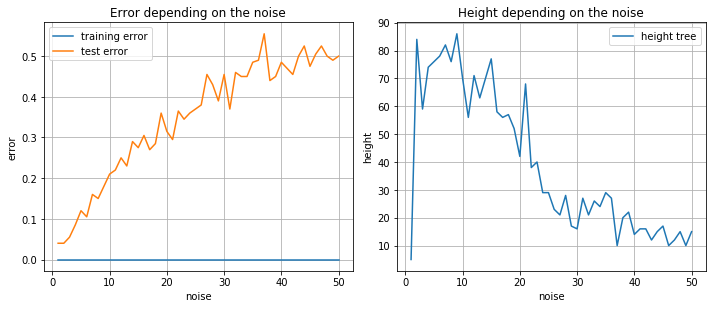

In [12]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # the label classes
attributes_list =[[0], [1]] # indexes of colum to be considered by the algorithm
Xtr, Ytr= mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # training set
Xte, Yte= mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # test set

step = 1
noise_list = np.arange(1, 50 + step , step)
print("noises: ",noise_list)
error_train = np.zeros(noise_list.size)
error_test = np.zeros(noise_list.size)
depth_list = np.zeros(noise_list.size)

for idx, noise in enumerate(noise_list):
    
    Ytr_noised = utils.flipLabels(Ytr, noise)
    Yte_noised = utils.flipLabels(Yte, noise)

    Dt = DecisionTree( float('+inf') , (Xtr,Ytr_noised), attributes_list, classes, DecisionTree.GINI) 
    Dt.train() 
    
    error_train[idx] = Dt.test(Xtr, Ytr_noised) [2]
    error_test[idx] = Dt.test(Xte, Yte_noised) [2]
    depth_list[idx] = Dt.getHeight()
    
plt.subplot(2,2,1)
plt.plot(noise_list, error_train, label= 'training error')
plt.plot(noise_list, error_test, label= 'test error')
plt.title("Error depending on the noise")
plt.xlabel('noise')
plt.ylabel('error')
plt.axis("tight")
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(noise_list, depth_list, label= 'height tree')
plt.title("Height depending on the noise")
plt.xlabel('noise')
plt.ylabel('height')
plt.axis("tight")
plt.legend()
plt.grid()

plt.tight_layout()

How we can see from the plots, adding noise:
* the training error is always 0.0 because the tree overfit the training set
* the test error increases with the noise
* as the noise increases, the tree's height decreases and reach the minimum when the noise is the highest

If the training set is a little noised, then the algorithm needs to split the data several times (using different tests) to find pure partitions which are composed of one point (the noised point) and that's the reason why the height is greater in this case.

The depth decreases because the algorithm, finding chunks of many points belonging to the same class (even if they are noise), doesn't need so much tests in order to get pure partitions.

This situation can be resolved adding a new terminal condition to the algorithm such that if the number of training samples passed to node if equal or less of a given *number* then the node becomes a leaf labeled with the most common class of the points, otherwise the node can continue to split the data and create new children. In this way we make the decision tree less sensitive to data and reduce overfitting.

We are interested in the height because it determines the computational complexity for both train and prediction procedures.

### Limiting the height

Decision trees solve both linear and nonlinear problems without changing the implementation so the real dataset about the breast cancer can be considered.
let's see what's happen if the maximum depth, that the tree can reach, is limited: what we expect deeper the tree, the more complex the model become.

Here 80% of the dataset goes to the training set and the remaining 20% represents the test set.

depths:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


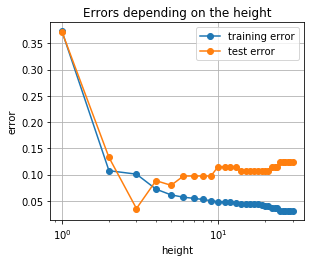

In [22]:
step = 1
depth_list = list(np.arange(1, 30 + step , step))
print("depths: ",depth_list)
error_train = np.zeros(np.size(depth_list))
error_test = np.zeros(np.size(depth_list))

classes = classes_cancer # the label classes
attributes_list = attributes_cancer # indexes of colum to be considered by the algorithm

Xtr, Ytr, Xte, Yte = utils.splitData(X_cancer, Y_cancer, 0.8) # training set and test set

for idx, depth in enumerate(depth_list):
    
    Dt = DecisionTree(depth, (Xtr,Ytr), attributes_list, classes, DecisionTree.GINI) # the depth is limited using the first parameter
    Dt.train() 
    error_train[idx] = Dt.test(Xtr, Ytr) [2]
    error_test[idx] = Dt.test(Xte, Yte) [2]

fig = plt.figure(figsize=(10,8)) 

ax = fig.add_subplot(2, 2, 1)
ax.semilogx(depth_list, error_train, '-o', label= 'training error')
ax.semilogx(depth_list, error_test, '-o',label= 'test error')
ax.set_title("Errors depending on the height")
ax.set_xlabel('height')
ax.set_ylabel('error')
ax.axis("tight")

plt.legend()
plt.grid()


As we can expect the training error decrease with increasement of the height.
Meanwhile the test error starts decreasing, at some depth reach a minimum, and then it encreases until it stablilizes.

In fact if the maximum depth is too high, then the decision tree overfit the training set without capturing the useful patterns as we are looking for. But if it is too low the algorithm results in an underfit model.
This suggests that the height can be used as a parameter in order to prevent overfitting.

### Pruning the tree

Prune the tree is another method that helps to control overfitting, the decision tree is let to grow as much as possible and then it is pruned using *Reduce Error Pruning* algorithm.
the dataset must be divided into 2 sets: test set and training set, then the latter is further splitted into 2 sets so that the first (let's call it as "Xtr_train" and "Ytr_train") is used to train the model and the second (pruning set) is used to prune the tree.
If the test set is fixed how does it change using different size of pruning set? An average result will be considered because a small change in the training set can lead to a completely different Decision tree.

sizes:  [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


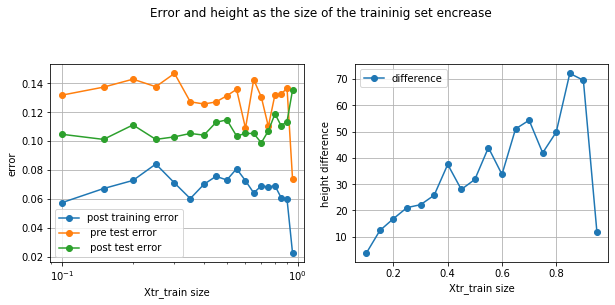

In [40]:
step = 0.05
nRepetition = 10
p_list = np.arange(0.1, 0.99 , step) # percentuages
print("sizes: ",p_list)

# means 
error_post_train = np.zeros(p_list.size)
error_pre_test = np.zeros(p_list.size)
error_post_test = np.zeros(p_list.size)
depth_pre_list = np.zeros(p_list.size) # depth pre pruning
depth_post_list = np.zeros(p_list.size) # depth post pruning
depth_difference = np.zeros(p_list.size) # difference between depth pre pruning and depth post pruning

classes = classes_cancer # the label classes
attributes_list = attributes_cancer # indexes of colum to be considered by the algorithm
Xtr, Ytr, Xte, Yte = utils.splitData(X_cancer, Y_cancer, 0.7) # training set and test set

for idx, p in enumerate(p_list):
    for i in range(nRepetition):
        
        # the training set encreases
        Xtr_train, Ytr_train, Xtr_prun, Ytr_prun = utils.splitData(Xtr, Ytr, p) # p data points go to pruning set
        Dt = DecisionTree( float('+inf') , (Xtr_train, Ytr_train), attributes_list, classes, DecisionTree.GINI) 
        Dt.train()
        depth_pre_list[idx] += Dt.getHeight()
        error_pre_test[idx] += Dt.test(Xtr_prun, Ytr_prun) [2]
        Dt.pruning(Xtr_prun, Ytr_prun)
        # calc error post pruning
        error_post_train[idx] += Dt.test(Xtr_train, Ytr_train) [2] # training error post pruning
        error_post_test[idx] += Dt.test(Xte, Yte) [2]
        depth_post_list[idx] += Dt.getHeight()
        
    # means are calculated
    error_post_train[idx] /= nRepetition
    error_pre_test[idx] /= nRepetition
    error_post_test[idx] /= nRepetition
    depth_pre_list[idx] /= nRepetition
    depth_post_list[idx] /= nRepetition
    depth_difference[idx] = depth_pre_list[idx] - depth_post_list[idx]

    
fig = plt.figure(figsize=(10,8))
plt.suptitle("Error and height as the size of the traininig set encrease")

ax0 = fig.add_subplot(2, 2, 1)
ax0.semilogx(p_list, error_post_train, '-o',label= 'post training error')
ax0.semilogx(p_list, error_pre_test, '-o',label= ' pre test error')
ax0.semilogx(p_list, error_post_test, '-o',label= ' post test error')
ax0.set_xlabel('Xtr_train size')
ax0.set_ylabel('error')
ax0.axis("tight")
ax0.legend()
ax0.grid()

ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(p_list, depth_difference, '-o',label= 'difference')
ax1.set_xlabel('Xtr_train size')
ax1.set_ylabel('height difference')
ax1.axis("tight")
ax1.legend()
ax1.grid()

plt.show()

I'll refer to the test error pre pruning as pre_error_test, and to the test error post pruning as post_error_test.

It starts assigning to Xtr_train and to the pruning set the 0.1 and 0.9 of the training set, respectively.
First the tests error are high because there aren't enough samples to train the model properly.
With the encreasement of Xtr_train's size the gap between the test errors (pre e post pruning) decreases and at the same time also the gap with the training error does so, until post_error_test is equal or bigger than pre_error_test; this happens when the pruning set is much smaller than the training set and actually the tree is a little bit pruned.

These results mean we need to balance the size of the Xtr_train and the pruning set in order to have a tree such that the test error is as small as possible and the post_error_test is smaller than pre_error_test.
Moreover another aim of the pruning algorithm is to get a new tree smaller than the original to improve efficiency.

For such method a lot of data are required for both training set and pruning set in order to achieve better results.

# Real dataset: cross validation

Breast cancer dataset is divided into the training set and the test set .

In [ ]:
classes = classes_cancer
attributes_list = attributes_cancer
Xtr, Ytr, Xte, Yte = utils.splitData(X_cancer, Y_cancer, 0.7) # training set and test set
print("Training set size: ",Ytr.shape[0])
print("Test set size: ",Yte.shape[0])

### Find the best max depth parameter
K-fold cross validation over the max depth using my own implementation.

[2]
Test error:  0.07647058823529412


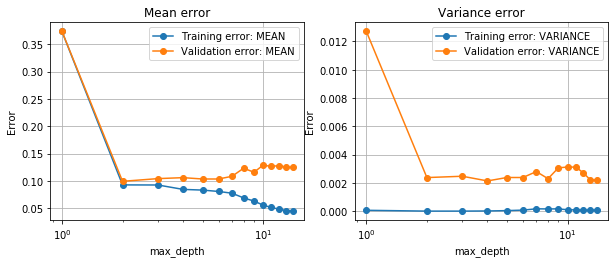

In [64]:
depth_list = np.arange(1, 15)

KF = 15

best_depth_list, Vm, Vs, Tm, Ts = KFoldCVBestDepth_MyImplementation(Xtr, Ytr, attributes_list, classes, DecisionTree.GINI, KF, depth_list) 
print(best_depth_list) 
best_depth = best_depth_list[0]

DT = DecisionTree( best_depth, (Xtr,Ytr), attributes_list, classes, DecisionTree.GINI) 
DT.train()

Xte_p, Y_pred, err = DT.test(Xte, Yte)
print("Test error: ",err)

utils.plotErrorBestDepthMethod(Vm, Vs, Tm, Ts, depth_list)


The optimal max depth is 2 so the problem should be linearly separable, since it needs only 3 test to separate the data.

### Comparison between my implementation and ScikitLearn's implementation
Considering the implementation of the library ScikitLearn, using the same parameters: max_depth, min_samples_split (==2), min_samples_leaf (==1) and the same split criterion.

min_samples_split represents the minimum number of samples required to split an internal node, min_samples_leaf represents the minimum number of samples required to be at a leaf node.
These parameters in my implementation are not esplicitly used, but are implicitly in the terminals conditions.

### Find the best max depth parameter
K-fold cross validation over the max depth using Scikit's implementation.

[3]
Test error:  0.08823529411764706


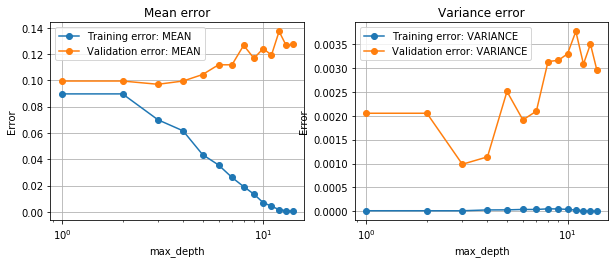

In [28]:
depth_list = np.arange(1, 15)

KF = 15

best_depth_list, Vm, Vs, Tm, Ts = KFoldCVBestDepth_ScikitImplementation(Xtr, Ytr, DecisionTree.GINI, KF, depth_list) 
print(best_depth_list) 
best_depth = best_depth_list[0]

clf = DecisionTreeClassifier(max_depth = best_depth)
trained = clf.fit(Xtr, Ytr)
teError = utils.calcError(clf.predict(Xte), Yte)

print("Test error: ", teError)

utils.plotErrorBestDepthMethod(Vm, Vs, Tm, Ts, depth_list)


The tests errors using Scikit and using my own implementation is almost similar without pruning.
Note that in my implementation if I set the max_depth equal to 1, the this means that the tree will have only the root as node (which is also a leaf).
Scikit uses the depth without considering the root: so if max_depth is sets to 1 then the resulting tree will have the root plus a layer of nodes which are its childern. This can explain the differnce between the plots at depth equal to 1.

# Multiclass problem
Decision trees are also able to recognize multiclass patterns.

Now I'll consider a dataset with 4 different classes.

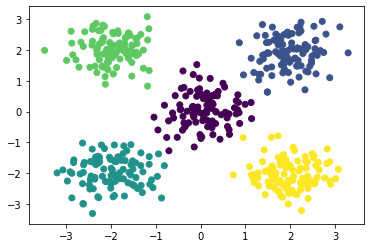

In [28]:
classes = [1, 2, 3, 4] # the label classes
attributes_list =[[0], [1]] # indexes of colum to be considered by the algorithm

Xtr, Ytr= mixGauss([[0, 0], [2, 2], [-2, -2], [-2, 2], [2, -2]], [0.5, 0.5, 0.5, 0.5, 0.5], 100)
Xte, Yte= mixGauss([[0, 0], [2, 2], [-2, -2], [-2, 2], [2, -2]], [0.5, 0.5, 0.5, 0.5, 0.5], 100)

plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr)

Test error:  0.03
Max depth:  5


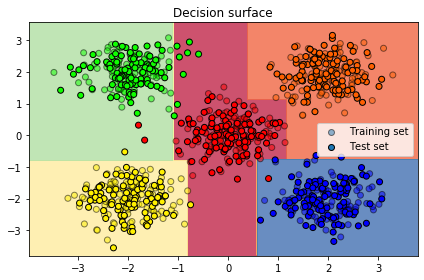

In [33]:
Dt = DecisionTree( float('+inf'), (Xtr,Ytr), attributes_list, classes, DecisionTree.ENTROPY) 
Dt.train() 

err = Dt.test(Xte, Yte) [2] 
print("Test error: ",err)
print("Height: ", Dt.getHeight())
utils.Area(Dt, Xtr, Ytr, Xte, Yte, plt.cm.Spectral, ListedColormap(['#FF0000','#FF6000','#FFF000' ,'#0FFF00','#0000FF'])) # training and test set are coincident in the plot

Since `h=5` is the height, the tree has up to $2^{h+1}-1=63$ nodes and $2^h=32$ of those are leaves.
In the case seen before, with the binary dataset, the tree has up to 7 nodes and 4 of those are leaves.

As a result the algorithm can achieve good accuracy even though the computation can easily become very complex as the number of classes increases.

### real dataset

Now, in the following code is considered the the Iris dataset presentated before.

In [27]:
classes = classes_iris
attributes_list = attributes_iris
Xtr, Ytr, Xte, Yte = utils.splitData(X_iris, Y_iris, 0.7) # training set and test set
print("Training set size: ",Ytr.shape[0])
print("Test set size: ",Yte.shape[0])

Training set size:  105
Test set size:  45


### Find the best max depth parameter
K-fold cross validation over the max depth using my own implementation.

Best depth:  [3]
Test error:  0.06666666666666667


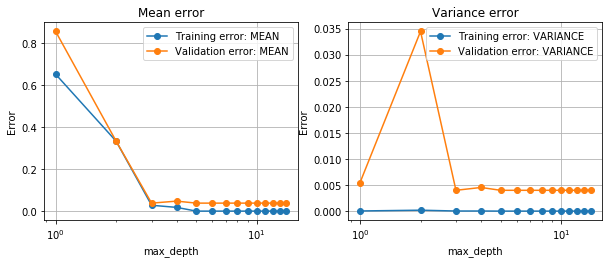

In [59]:
depth_list = np.arange(1, 15)

KF = 15

best_depth_list, Vm, Vs, Tm, Ts = KFoldCVBestDepth_MyImplementation(Xtr, Ytr, attributes_list, classes, DecisionTree.GINI, KF, depth_list) 
print("Best depth: ", best_depth_list) 
best_depth = best_depth_list[0]

DT = DecisionTree( best_depth, (Xtr,Ytr), attributes_list, classes, DecisionTree.GINI) 
DT.train()

Xte_p, Y_pred, err = DT.test(Xte, Yte)
print("Test error: ",err)

utils.plotErrorBestDepthMethod(Vm, Vs, Tm, Ts, depth_list)


Even though the dataset has 3 different classes, the tree has 3 as maximum depth and this probably means that the 3 classes are easily separable. But this situation can be also caused by the limited number of samples in the dataset.

Decision trees behave in the same way for both binary classification and multi-category classification problem and they don't require any adaptations at the implemetation level, actually they can work with an arbitrary number of classes.


In conclusion, the decision tree algorithm is so general that can be use for linear and nonlinear problems and with an arbitrary number of classes, but it gives lower accuracy compared to other machine learning algorithms.